# COGS 118B - Final Project

# Something about tetris! 

## Group members

- Katy Stadler
- Elvin Li
- Jiasheng Zhou
- Harry Wang

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

Tetris is a video game created by a Russian software engineer that became popular worldwide. In the game, there is a grid-environment where differently shaped blocks “fall” from the top of the grid to the bottom. It is the user’s job to arrange the blocks (by moving them left and right and/or rotating them) so that they can survive as long as possible without any of the blocks accumulating all the way to the top of the grid. Rows can be dissolved (therefore giving the user more space) if every single grid in a row is filled by any part of a block (a ‘tetris’ is a quadruple of rows filled and cleared at the same time) [<sup>[1]</sup>](#historyoftetrisnote). Strategy for the game involves trying to maximize the number of cleared rows and tetrises, especially when the goal is to receive as many points as possible. In the situation where the goal is to “stay alive” as long as possible, the main goal is to keep the highest block as low as possible, often by virtue of row-clearings and/or tetrises.

A 2013 paper introduced the Arcade Learning Environment (ALE) [<sup>[2]</sup>](#alenote) that we plan to utilize in this project. ALE’s goal is to provide an interface to hundreds of Atari game environments, as well as methods to evaluate and compare approaches used to train agents in these games. There are different methods for feature construction and three simple baseline agents: Random, which picks a random action every frame, Const, which picks a single action throughout an episode, and Perturb, which selects a fixed action with a 95% probability and is uniformly random otherwise. 

It has been proven that even in an offline version of Tetris, it is NP-complete to “maximize the number of cleared rows, maximize the number of tetrises, minimize the maximum height of an occupied square, or maximize the number of pieces played before the game ends” [<sup>[3]</sup>](#nphardnote). These results held when players were restricted to only 2 rotation/translation moves before each piece drops in height, restricted piece sets, and with an infinitely tall gameboard. This is why we are interested in testing the performance of different models and hyperparameters as we train an agent to play the game.

Even before the 2013 ALE was released, there were several attempts at training an agent to play Tetris. In 1996, Tsitsiklis & Van Roy used feature-based dynamic programming (number of holes and height of the highest column) to achieve a score of around 30 cleared lines on a 16x10 grid [<sup>[4]</sup>](#dpnote). In the same year, Bertsekas & Tsitsiklis added the height of each column and the difference in height between adjacent columns as features. They achieved a higher score of 2800 lines using lambda-policy iteration [<sup>[5]</sup>](#lambdaitnote). Later, even further features were added, including mean column height and the sum of the differences in adjacent column height. Least-squares policy iteration achieved an average score of between 1000 and 3000 lines [<sup>[6]</sup>](#leastsquaresitnote). 

Due to the design of Tetris, it doesn’t really make sense to have a reward function that gives rewards only at the end of the game. One TD(0)-Learning implementation uses linear combinations of weighted features, such as the value of the highest-used column, the average of the heights of all used columns, the number of holes between pieces at each given time, and the “quadratic unevenness” of the profile (which is a result of summing the squared values of the differences of neighboring columns) [<sup>[7]</sup>](#egreedynote). In order to reduce the state space, a constrained height difference between adjacent columns was used to encode each state. In this experiment, it was shown that lower values of ε were beneficial when using an epsilon-greedy policy.

Tetris can also be modeled as a Markov Decision process if its state space is somehow reduced. Without reduction, a simple 20x10 board has 2200 ways to fill it and even with the requirement that no row be completely full, this is still (210 - 1)20. This 2022 paper’s [<sup>[8]</sup>](#mdpnote) most successful approach, “Fitted Value Iteration”, chose a small set of features and represented each state in terms of this set of features. This method was contingent upon “featurization” of the MDP and a small number of samples from the original state space needed to represent the state-value relationship. The article also found that the features Max-Height, Num-Holes, and Num-Covers were promising features when it came to training an agent.

# Problem Statement

Clearly describe the problem that you are solving. Avoid ambiguous words. The problem described should be well defined and should have at least one ML-relevant potential solution. Additionally, describe the problem thoroughly such that it is clear that the problem is quantifiable (the problem can be expressed in mathematical or logical terms), measurable (the problem can be measured by some metric and clearly observed), and replicable (the problem can be reproduced and occurs more than once).

# Data (instructions, to delete)

Detail how/where you obtained the data and cleaned it (if necessary)

If the data cleaning process is very long (e.g., elaborate text processing) consider describing it briefly here in text, and moving the actual clearning process to another notebook in your repo (include a link here!).  The idea behind this approach: this is a report, and if you blow up the flow of the report to include a lot of code it makes it hard to read.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!

# Data
Since we hope to measure the learning algorithms’ development of strategies, using past data for our experiments doesn’t align with the current goal of measuring RL-strategy effectiveness. Instead, we will generate data dynamically through live simulations, allowing our models to learn through interaction with the environment. One such environment that can foster this is Farama’s tetris environment (https://gymnasium.farama.org/environments/atari/tetris/), which provides a retro Tetris setup for reinforcement learning research. Training models in this environment is analogous to collecting data, as the agent improves its actions and policies through multiple iterations of gameplay, guided by a reward system (e.g. based on the number of rows cleared per episode). The environment offers a discrete action space with five possible moves: move left, move right, drop down, rotate, and no operation (NOOP). The game state is represented through an interface that can be launched in Python, with observations encoded as RGB pixel values.


### Below, we will load the environment and display.

In [5]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics


Episode 1: Total Reward = 0


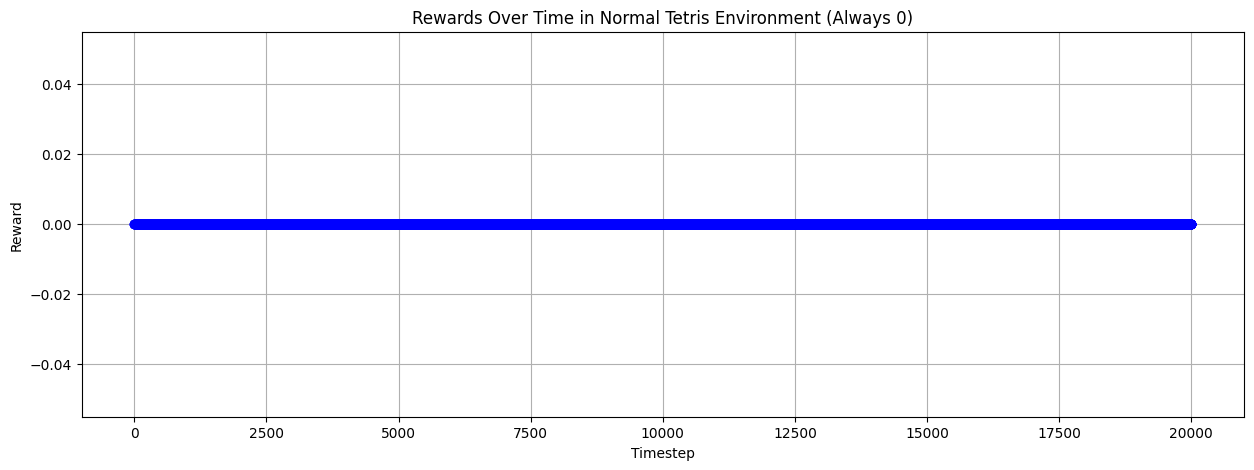

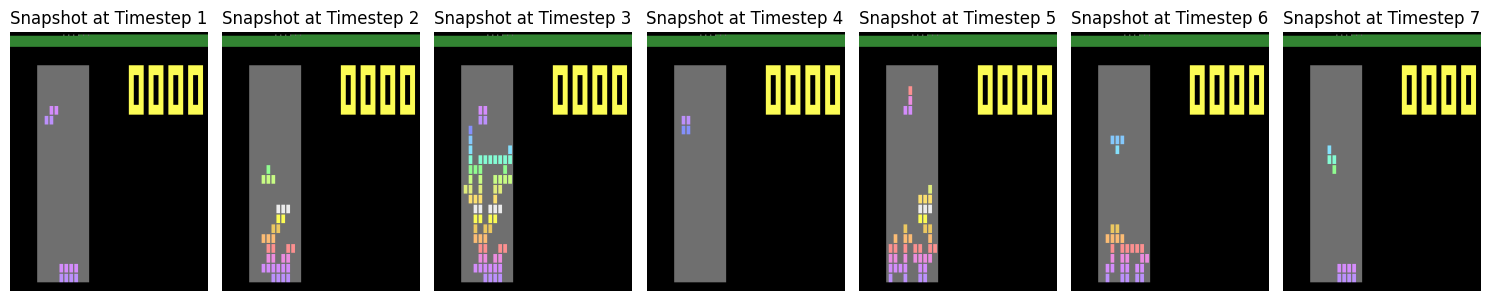

In [8]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("ALE/Tetris-v5", render_mode="rgb_array")

num_episodes = 1
timesteps_per_episode = 20000
accumulated_rewards = []
snapshots = []

for episode in range(num_episodes):
    obs, info = env.reset()
    total_reward = 0

    for t in range(timesteps_per_episode):
        action = env.action_space.sample()  # Take a random action
        obs, reward, done, truncated, _ = env.step(action)
        
        accumulated_rewards.append(reward)  # Collect the reward at each timestep
        
        if t in [100, 300, 500, 1000, 2500, 5000, 9999]:  # Example of when to capture frames
            snapshots.append(obs)

        if done or truncated:
            obs, info = env.reset()  # Reset the environment at the end of the episode

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

plt.figure(figsize=(15, 5))
plt.plot(accumulated_rewards, marker="o", linestyle="-", color="b")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Rewards Over Time in Normal Tetris Environment (Always 0)")
plt.grid(True)
plt.show()

num_snapshots = len(snapshots)
fig, axes = plt.subplots(1, num_snapshots, figsize=(15, 5))

if num_snapshots == 1:
    axes = [axes]

for i, frame in enumerate(snapshots):
    axes[i].imshow(frame)
    axes[i].axis("off")
    axes[i].set_title(f"Snapshot at Timestep {i + 1}")

plt.tight_layout()
plt.show()

env.close()


# Proposed Solution

In this section, clearly describe a solution to the problem. The solution should be applicable to the project domain and appropriate for the dataset(s) or input(s) given. Provide enough detail (e.g., algorithmic description and/or theoretical properties) to convince us that your solution is applicable. Make sure to describe how the solution will be tested.  

If you know details already, describe how (e.g., library used, function calls) you plan to implement the solution in a way that is reproducible.

If it is appropriate to the problem statement, describe a benchmark model<a name="sota"></a>[<sup>[3]</sup>](#sotanote) against which your solution will be compared. 

# Evaluation Metrics

Propose at least one evaluation metric that can be used to quantify the performance of both the benchmark model and the solution model. The evaluation metric(s) you propose should be appropriate given the context of the data, the problem statement, and the intended solution. Describe how the evaluation metric(s) are derived and provide an example of their mathematical representations (if applicable). Complex evaluation metrics should be clearly defined and quantifiable (can be expressed in mathematical or logical terms).

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Probably you should include a learning curve to demonstrate how much better the model gets as you increase the number of trials

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Generally reinforement learning tasks may require a huge amount of training, so extensive grid search is unlikely to be possible. However expoloring a few reasonable hyper-parameters may still be possible.  Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?  Or you compare a completely different approach/alogirhtm to the problem? Whatever, this stuff is just serving suggestions.



# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.


### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   


### Future work
Looking at the limitations and/or the toughest parts of the problem and/or the situations where the algorithm(s) did the worst... is there something you'd like to try to make these better.

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<!--
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
-->

<a id="historyoftetrisnote"></a>  
**¹** Weisberger, M. (13 Oct 2016) The Bizarre History of 'Tetris'. *LiveScience*. https://www.livescience.com/56481-strange-history-of-tetris.html <br>
<a id="alenote"></a> **²** Bellemare, M. et al. (14 Jun 2013) The Arcade Learning Environment: An Evaluation Platform for General Agents. *Journal of Artificial Intelligence Research*. https://jair.org/index.php/jair/article/view/10819 <br>
<a id="nphardnote"></a> **³** Demaine, E. et al. (21 Oct 2002) Tetris is Hard, Even to Approximate. arXiv.org. https://arxiv.org/abs/cs/0210020 <br>
<a id="dpnote"></a> **⁴** Tsitsiklis, J., Van Roy, B. (5 May 1996) An Analysis of Temporal-Difference Learning with Function Approximation. *IEEE TRANSACTIONS ON AUTOMATIC CONTROL*. https://www.mit.edu/~jnt/Papers/J063-97-bvr-td.pdf <br>
<a id="lambdaitnote"></a> **⁵** Bertsekas, D., Tsitsiklis, J. (1996) Neuro-Dynamic Programming. *Athena Scientific* <br>
<a id="leastsquaresitnote"></a> **⁶** Lagoudakis, M. et al. (2002) Least-squares methods in reinforcement learning for control. *Hellenic Conference on Artificial Intelligence* <br>
<a id="egreedynote"></a> **⁷** Thiam, P. et al. (2014) A Reinforcement Learning Algorithm to Train a Tetris Playing Agent. *Artificial Neural Networks in Pattern Recognition*. https://link.springer.com/chapter/10.1007/978-3-319-11656-3_15 <br>
<a id="mdpnote"></a> **⁸** Bodoia, M., Puranik, A. (2022) Applying Reinforcement Learning to Competitive Tetris. https://cs229.stanford.edu/proj2012/BodoiaPuranik-ApplyingReinforcementLearningToCompetitiveTetris.pdf 